In [ ]:
# google drive link
!gdown 'https://drive.google.com/u/1/uc?id=1Kspfhle9vIqG9xR1Wf-ltE_qm06SOirJ&export=download'
!gdown 'https://drive.google.com/u/1/uc?id=1KcpuMeLZruwTKVp0ix9IIqIny6m-ih6l&export=download'
!gdown 'https://drive.google.com/u/1/uc?id=1KxmyhqaHIDFMVxWpO9a_KmzwLt0orNoD&export=download'

Downloading...
From: https://drive.google.com/u/1/uc?id=1Kspfhle9vIqG9xR1Wf-ltE_qm06SOirJ&export=download
To: /content/sample_hbb.csv
100% 56.7M/56.7M [00:01<00:00, 41.8MB/s]
Downloading...
From: https://drive.google.com/u/1/uc?id=1KcpuMeLZruwTKVp0ix9IIqIny6m-ih6l&export=download
To: /content/sample_q.csv
100% 48.5M/48.5M [00:00<00:00, 94.3MB/s]
Downloading...
From: https://drive.google.com/u/1/uc?id=1KxmyhqaHIDFMVxWpO9a_KmzwLt0orNoD&export=download
To: /content/sample_test.csv
100% 52.6M/52.6M [00:00<00:00, 72.1MB/s]


In [ ]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

import matplotlib.pyplot as plt

In [ ]:
def load_samples(filename):
    print('load from', filename)
    fin = open(filename)
    lines = fin.readlines()
    idx_cur, samples, evt = -1, [], []
    for l in lines[1:]:
        idx, code, px, py, pz = l.split(',')
        if idx_cur != int(idx):
            idx_cur = int(idx)
            if len(evt) > 0:
                samples.append(evt)
                evt = []
        else:
            evt.append([int(code), float(px), float(py), float(pz)])
    samples.append(evt)
    print(len(samples), 'events loaded.')
    return samples


def prepare_features(samples):
    features = []
    charge = [0, -1 ,+1 ,-1 ,+1 ,-1 ,+1 ,0]
    for evt in samples:
        nr_feat = 6
        feat = np.zeros(8*nr_feat + 2)
        px = py = pz = totE = 0.
        for p in evt:
            code = p[0]
            px += p[1]
            py += p[2]
            pz += p[3]
            E = (p[1]**2+p[2]**2+p[3]**2)**0.5
            totE += E
            feat[p[0] *nr_feat : (p[0]+1) *nr_feat] += np.array([1, charge[p[0]], p[1], p[2], p[3], E])
        M = (totE**2 - (px**2+py**2+pz**2))**0.5
        feat[-1] = M
        feat[-2] = totE
        features.append(feat)
        # for p in evt:
        # features.append([len(evt)/100., M/100.])
    return features


def normalize(x_train, x_test):
  scale = np.mean(x_train, axis=0)
  scale[scale == 0] = 1
  x_train = x_train/scale
  x_test = x_test/scale

  return x_train, x_test

In [ ]:
def train_valid_split(X, y, valid_ratio, seed):
    np.random.seed(seed)
    '''Split provided training data into training set and validation set'''
    if valid_ratio != 0:
      val_size = int(valid_ratio * len(X)) 
      train_set_size = len(X) - val_size
      idx = np.random.permutation(len(X))
      x_train = X[idx[val_size:]]
      x_val = X[idx[:val_size]]
      y_train = y[idx[val_size:]]
      y_val = y[idx[:val_size]]
      return x_train, y_train, x_val, y_val
    
    return X, y, np.zeros(1), np.zeros(1)

In [ ]:
sample_sig = load_samples('./sample_hbb.csv')
sample_bkg = load_samples('./sample_q.csv')
sample_test = load_samples('./sample_test.csv')

In [ ]:
x_train_org = np.array(prepare_features(sample_sig)+prepare_features(sample_bkg))
y_train_org = np.array([1]*len(sample_sig)+[0]*len(sample_bkg))
x_test_org = np.array(prepare_features(sample_test))

In [ ]:
config = {'seed':1126,
      'valid_ratio': 0.}

In [ ]:
y_train = y_train_org
X_train, X_test = normalize(x_train_org, x_test_org)
X_train, y_train, X_valid, y_valid = train_valid_split(X_train, y_train, config['valid_ratio'], config['seed'])
# Print out the data size.
print(f"""train_data size: {X_train.shape}
valid_data size: {X_valid.shape}
test_data size: {X_test.shape}
{y_train.shape}""")

train_data size: (80000, 50)
valid_data size: (1,)
test_data size: (40000, 50)
(80000,)


In [ ]:
pd.DataFrame(X_train).describe()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,80000.000000,80000.0,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,...,80000.000000,80000.000000,80000.000000,80000.0,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,0.494030,0.0,567.730179,287.090609,297.120259,0.637675,2.254322,2.254322,421.434863,209.766662,...,193.682965,0.557235,0.622670,0.0,297.242048,644.876944,315.895731,1.005494,0.287805,0.504671
min,0.000000,0.0,-3058.265642,-1965.695170,-2271.535821,0.000000,0.000000,-0.000000,-10908.652013,-4959.274795,...,-1609.111707,0.007493,0.000000,0.0,-2315.426909,-4719.387526,-3624.966153,0.000000,0.403817,0.038576
25%,0.670585,0.0,-365.260068,-183.851499,-136.364292,0.555574,0.000000,-0.000000,0.000000,-0.000000,...,-98.054598,0.621611,0.586422,0.0,-116.420211,-253.993166,-84.574363,0.265113,0.800720,0.653473
50%,0.938818,0.0,0.118510,0.284386,1.208526,0.877629,0.000000,-0.000000,0.000000,-0.000000,...,0.832582,0.900784,0.879633,0.0,0.000000,-0.000000,-0.000000,0.730096,0.931081,1.018217
75%,1.274111,0.0,365.688516,186.216892,138.387694,1.302752,0.000000,0.000000,0.000000,0.000000,...,99.893316,1.257877,1.466055,0.0,118.763312,257.734798,86.777981,1.401430,1.131976,1.189404
max,4.358800,0.0,2686.398895,1530.940165,2309.462674,7.414324,20.303280,20.303280,7954.795124,5365.749666,...,1390.987091,6.790838,5.277799,0.0,2190.274253,5637.888146,3674.758053,12.165139,3.088096,5.581247


In [ ]:
rf = RandomForestClassifier(n_estimators=400, max_depth=20)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=400)

In [ ]:
y_pred = rf.predict(X_test)

In [ ]:
fout = open('my_predicts.csv', 'w')
fout.write("id,class\n")
for idx, p in enumerate(y_pred):
    fout.write('%d,%d\n' % (idx, p > 0.5))
fout.close()

In [ ]:
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8585


In [ ]:
feat_name = []
code = ['n', 'charge', 'px', 'py', 'pz', 'E']
for i in range(8):
    for j in range(6):
        feat_name.append(f'{i} {code[j]}')
feat_name.append('totE')
feat_name.append('M')

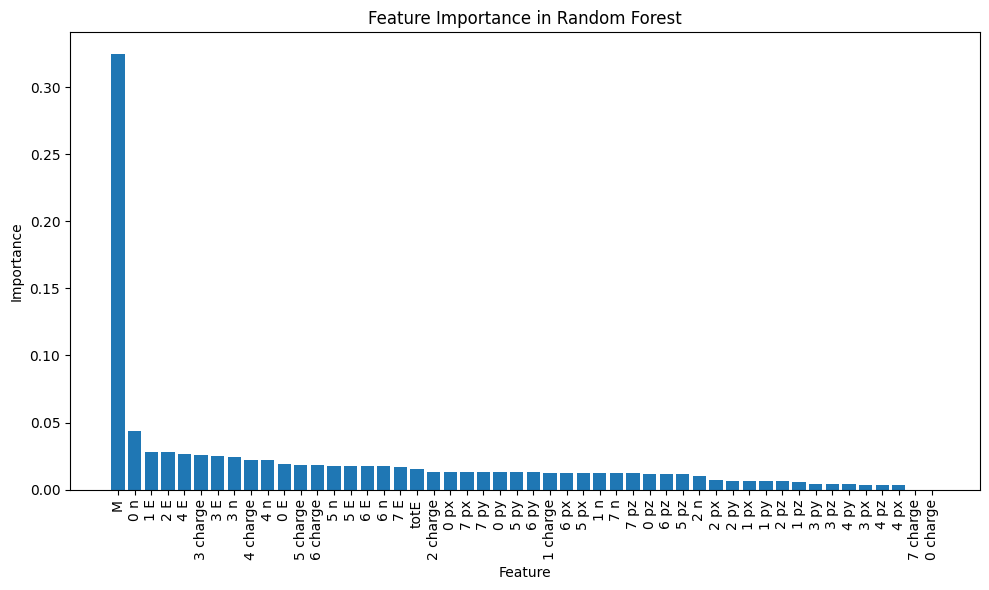

In [ ]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort indices in descending order
feature_names = feat_name  # Replace with your actual feature names
sorted_feature_names = [feature_names[i] for i in indices]
sorted_importances = importances[indices]

# import graphviz
import matplotlib.pyplot as plt

# Create a bar plot of feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, align='center')
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance in Random Forest')
plt.tight_layout()

In [ ]:
param_dist = {'n_estimators': randint(300,600),
              'max_depth': randint(15,30)}
rf = RandomForestClassifier()

rand_search = RandomizedSearchCV(rf, 
                  param_distributions = param_dist, 
                  n_iter=5, 
                  cv=5)
rand_search.fit(X_train, y_train)
best_rf = rand_search.best_estimator_
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 18, 'n_estimators': 371}


In [ ]:
rand_search.cv_results_

{'mean_fit_time': array([  7.47939739, 104.00871153, 108.39028745,  62.3551332 ,
         52.15144486]),
 'std_fit_time': array([0.30933188, 1.29333866, 2.54215086, 0.40854641, 0.58334189]),
 'mean_score_time': array([0.08640676, 0.97472816, 0.88049717, 0.54328151, 0.55025783]),
 'std_score_time': array([0.01280913, 0.07509242, 0.01146283, 0.01195899, 0.07984694]),
 'param_max_depth': masked_array(data=[4, 18, 13, 16, 5],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[83, 371, 474, 239, 486],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 4, 'n_estimators': 83},
  {'max_depth': 18, 'n_estimators': 371},
  {'max_depth': 13, 'n_estimators': 474},
  {'max_depth': 16, 'n_estimators': 239},
  {'max_depth': 5, 'n_estimators': 486}],
 'split0_test_score': array([0.76445312, 0.86296875, 0.85929687, 0.860468

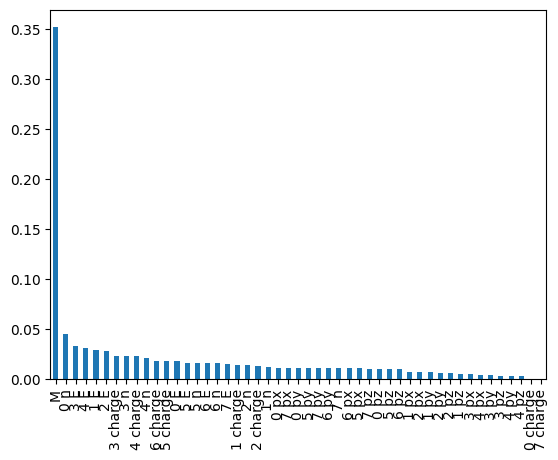

In [ ]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=feat_name).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();